In [8]:
import argparse
import logging
import os
import random
import sys
import glob
import cv2
import pickle
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split


from utils.data_loading import BasicDataset, OkraDataset

ln: failed to create symbolic link './utils': File exists


In [9]:
# 1. Create dataset
dir_img = Path('./training_data/okra_images/class_okra_surface')
dir_mask = Path('./training_data/okra_segmentation_target_masks')
dir_checkpoint = Path('./checkpoint')
img_scale = 0.2
dataset = OkraDataset(dir_img, dir_mask, img_scale)

100%|██████████| 31/31 [00:14<00:00,  2.19it/s]


In [10]:
print(dataset.ids)

['IMG_9156', 'IMG_9164', 'IMG_9155', 'IMG_9161', 'IMG_9185', 'IMG_9186', 'IMG_9177', 'IMG_9182', 'IMG_9197', 'IMG_9211', 'IMG_9212', 'IMG_9189', 'IMG_9219', 'IMG_9227', 'IMG_9224', 'IMG_9223', 'IMG_9220', 'IMG_9232', 'IMG_9231', 'IMG_9252', 'IMG_9235', 'IMG_9268', 'IMG_9263', 'IMG_9267', 'IMG_9275', 'IMG_9280', 'IMG_9284', 'IMG_9276', 'IMG_9283', 'IMG_9291', 'IMG_9292']


In [11]:
# 2. Split into train / validation partitions
val_percent = 0.1
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
# print("n_val = ", n_val, ", n_train = ", n_train)
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

In [12]:
# 3. Create data loaders
batch_size = 1
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, drop_last=True, **loader_args)

# batch_size = 2 ==> torch.Size([2, 3, 3024, 4032]) x18
# batch_size = 3 ==> torch.Size([3, 3, 3024, 4032]) x12
#
# for batch in train_loader:
#  images, true_masks = batch['image'], batch['mask']
#  print(images.shape)

In [21]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_image_with_mask(image, mask, iter_cnt, img_name):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.title(f"Mask for image # {iter_cnt} {img_name}", fontsize=18)
    # plt.axis('off')
    plt.show()

In [14]:
# preprocess = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

it = iter(test_loader)
iter_cnt = 0

In [15]:
try:
  sample_batch = next(it)
  iter_cnt += 1
  print("image # ", iter_cnt)
except StopIteration:
  print("Reached end of iteration. last count is ", iter_cnt)
except Exception as e: print(e)

image #  1


images.shape =  <class 'torch.Tensor'> torch.float32 torch.Size([3, 604, 806])
true_masks.shape =  <class 'torch.Tensor'> torch.bool torch.Size([1, 604, 806])


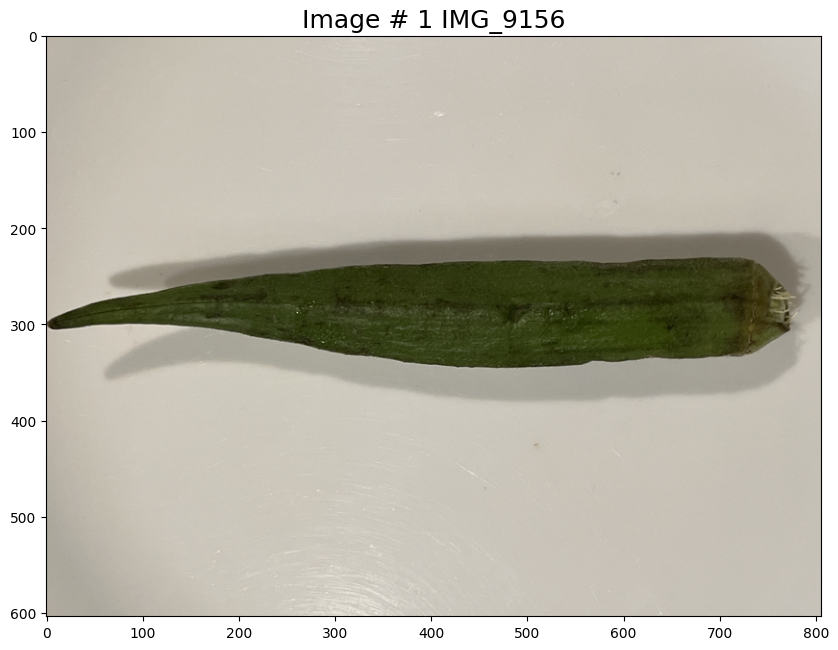

In [24]:
image, mask = sample_batch['image'], sample_batch['mask']

img_tensor = image.squeeze(0)
img_nparray = img_tensor.permute(1, 2, 0).numpy()

neg_mask = ~true_mask

print("images.shape = ", type(img_tensor) , img_tensor.dtype , img_tensor.shape)
print("true_masks.shape = ", type(true_mask), true_mask.dtype, true_mask.shape)

plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"Image # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img_nparray)

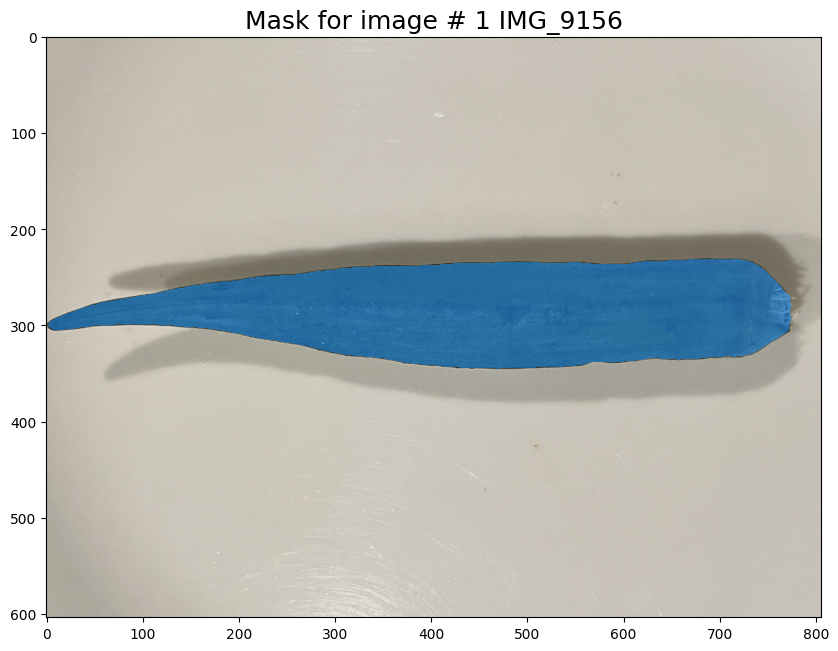

In [25]:
show_image_with_mask(img_nparray, mask, iter_cnt, img_name)